# 2024 MFIN 602 Team Project 

Here is list of tasks:
Construct a portfolio of stocks in the Energy sector/industry and government bonds. 
Collect financial data of the companies in the Energy sector/industry. See the list of names on the references Excel sheet. Use Refinitiv or Bloomberg to collect data. 

## PART A. 
Choose 5-to-10 stocks for your portfolio according to their “Valuation” and “Price Momentum”. 

1.	Explain what measures of “Valuation” and “Momentum” do you use and why.

2.	Which stocks do you choose? Explain the reasoning and method.

3.	What are the weights of stocks? How do you decide? 

In [92]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import itertools
file_path = 'data/temp_602_data.xlsx'
df_header = pd.read_excel(file_path,header=0)
df = pd.read_excel(file_path,header=1)
df.head()

,Dates,RSI_14D,REL_SHR_PX_MOMENTUM,PX_CLOSE_1D,CURRENT_EV_TO_T12M_EBITDA,PE_RATIO,RSI_14D.1,REL_SHR_PX_MOMENTUM.1,PX_CLOSE_1D.1,CURRENT_EV_TO_T12M_EBITDA.1,...,RSI_14D.30,REL_SHR_PX_MOMENTUM.30,PX_CLOSE_1D.30,CURRENT_EV_TO_T12M_EBITDA.30,PE_RATIO.30,RSI_14D.31,REL_SHR_PX_MOMENTUM.31,PX_CLOSE_1D.31,CURRENT_EV_TO_T12M_EBITDA.31,PE_RATIO.31
0,2023-10-31,54.4262,13.1222,12.20,11.3908,16.7498,50.1156,22.5592,12.58,9.2570,...,43.2394,8.7538,83.60,8.6212,20.2732,35.8832,16.9063,26.09,9.7094,77.0548
1,2023-11-01,61.6514,13.6700,12.34,11.5694,17.1570,60.3212,23.1530,12.67,9.4623,...,46.0134,9.1463,83.61,8.6524,20.4041,35.0637,16.7608,26.14,9.6913,77.0548
2,2023-11-02,67.4024,14.2077,12.64,11.7540,17.5777,68.4889,23.8276,13.18,9.6881,...,66.1428,9.8181,84.15,8.9876,21.8832,61.7304,16.9874,26.05,10.2188,77.0548
3,2023-11-03,66.3652,14.6169,12.95,11.7361,17.5370,73.2355,24.7095,13.78,9.8807,...,58.0093,10.2280,90.25,8.8650,21.3668,66.8476,17.4230,28.60,10.3983,77.0548
4,2023-11-06,64.5814,15.1469,12.92,11.7064,17.4692,66.2905,25.7792,14.26,9.7563,...,55.9903,11.4343,88.12,8.8316,21.2261,57.9415,18.0486,29.49,10.2067,77.0548


## Preprocessing Data
After parsing data from Bloomberg, we gain one Excel file.
We first need to preprocess the data to make it easier to work with.
1. Drop columns with all missing values, such as NaN or unrealistic values from the excel file. (Done in Excel)
2. Create data frames for each stock for easier manipulation.

In [93]:
# Create a dictionary to store all DataFrame
dfs = {}
# Get stock names
stock_names = df_header.columns[1::5].str.replace(" ", "_")
#check stock_names
print(stock_names)

Index(['AM_US_Equity', 'AROC_US_Equity', 'BOOM_US_Equity', 'CEIX_US_Equity',
       'CHX_US_Equity', 'CIVI_US_Equity', 'CLB_US_Equity', 'CNX_US_Equity',
       'CPE_US_Equity', 'DTM_US_Equity', 'ETRN_US_Equity', 'HLX_US_Equity',
       'HP_US_Equity', 'LPG_US_Equity', 'MTDR_US_Equity', 'MUR_US_Equity',
       'NOV_US_Equity', 'OII_US_Equity', 'OIS_US_Equity', 'PARR_US_Equity',
       'PBF_US_Equity', 'PTEN_US_Equity', 'PUMP_US_Equity', 'RES_US_Equity',
       'REX_US_Equity', 'RRC_US_Equity', 'SLCA_US_Equity', 'SM_US_Equity',
       'SWN_US_Equity', 'TALO_US_Equity', 'TRGP_US_Equity', 'VTOL_US_Equity'],
      dtype='object')


In [94]:
# Go through the stock name and create their own DataFrame
for i, stock_name in enumerate(stock_names):
    cols = ['Dates'] + list(df.columns[i*5 + 1:i*5 + 6])
    stock_df = df[cols].copy() 
    stock_df.columns = ['Dates', 'RSI_14D', 'REL_SHR_PX_MOMENTUM', 'PX_CLOSE_1D', 'CURRENT_EV_TO_T12M_EBITDA', 'PE_RATIO']
    # save the DataFrame to the dictionary
    dfs[f"{stock_name}_df"] = stock_df

# Check DataFrames
# for name, stock_df in dfs.items():
#     print(f"DataFrame for {name}:")
#     display(stock_df.head())  

## Explain what measures of “Valuation” and “Momentum” do you use and why.
We will use the following indicators to evaluate the valuation and momentum of each stock:
1. **Valuation**:
    - **Price-to-Earnings (P/E) Ratio**: The P/E ratio is a measure of a company's valuation. It indicates how much investors are willing to pay for each dollar of earnings. A lower P/E ratio may indicate that a stock is undervalued.
    - **EV/EBITDA Ratio**: The EV/EBITDA ratio is another valuation metric that compares a company's enterprise value to its earnings before interest, taxes, depreciation, and amortization. A lower EV/EBITDA ratio may indicate that a stock is undervalued.
2. **Momentum**:
    - **Relative Share Price Momentum**: The relative share price momentum measures the price momentum of a stock relative to the overall market. A positive relative share price momentum indicates that a stock is outperforming the market.
    - **RSI (Relative Strength Index)**: The RSI is a momentum oscillator that measures the speed and change of price movements. It ranges from 0 to 100 and is typically used to identify overbought or oversold conditions in a stock.
## Which stocks do you choose? Explain the reasoning and method.
We will choose the top 5 stocks based on the average ranking of the following indicators:
1. **RSI_14D**: The average 14-day RSI value.
2. **REL_SHR_PX_MOMENTUM**: The average relative share price momentum.
3. **CURRENT_EV_TO_T12M_EBITDA**: The average current enterprise value to trailing twelve months EBITDA ratio.
4. **PE_RATIO**: The average price-to-earnings ratio.
5. **TOTAL_RANK**: The sum of the rankings of the above four indicators.
6. **RETURNS**: The daily returns of each stock based on the closing price.
7. **Correlation Matrix**: The correlation matrix of the daily returns of each stock.
### Method: 
We will calculate the average value of each indicator for each stock and rank the stocks based on these averages. The lower the average rank, the higher the stock's position in the final selection. We pick the top 10 stocks based on the total rank and use volatility and Sharpe ratio optimization to select the best combination of stocks.

In [95]:
# Initialize an empty DataFrame to store the ranking information
rank_df = pd.DataFrame()

# Go through each stock DataFrame and calculate the average values of the indicators
for name, stock_df in dfs.items():
    stock_name = name.replace("_df", "")  

    # Calculate the average values of the indicators
    rsi_avg = stock_df['RSI_14D'].mean()
    momentum_avg = stock_df['REL_SHR_PX_MOMENTUM'].mean()
    ev_to_ebitda_avg = stock_df['CURRENT_EV_TO_T12M_EBITDA'].mean()
    pe_ratio_avg = stock_df['PE_RATIO'].mean()

    # Create a  DataFrame of the rank list based on the indicators in "valuation" and "momentum"
    rank_info = pd.DataFrame({
        "RSI_14D_AVG": [rsi_avg],
        "REL_SHR_PX_MOMENTUM_AVG": [momentum_avg],
        "CURRENT_EV_TO_T12M_EBITDA_AVG": [ev_to_ebitda_avg],
        "PE_RATIO_AVG": [pe_ratio_avg]
    }, index=[stock_name])

    # Use pd.concat adding rank information to rank_df
    rank_df = pd.concat([rank_df, rank_info])

# Calculate rank
rank_df["RSI_14D_RANK"] = rank_df["RSI_14D_AVG"].rank(ascending=True)
rank_df["REL_SHR_PX_MOMENTUM_RANK"] = rank_df["REL_SHR_PX_MOMENTUM_AVG"].rank(ascending=False)
rank_df["CURRENT_EV_TO_T12M_EBITDA_RANK"] = rank_df["CURRENT_EV_TO_T12M_EBITDA_AVG"].rank(ascending=True)
rank_df["PE_RATIO_RANK"] = rank_df["PE_RATIO_AVG"].rank(ascending=True)

# Sum up ranks 
rank_df["TOTAL_RANK"] = (
    rank_df["RSI_14D_RANK"]
    + rank_df["REL_SHR_PX_MOMENTUM_RANK"]
    + rank_df["CURRENT_EV_TO_T12M_EBITDA_RANK"]
    + rank_df["PE_RATIO_RANK"]
)

# Sort by TOTAL_RANK in ascending order
rank_df = rank_df.sort_values(by="TOTAL_RANK", ascending=True)

# Display the results
rank_df.reset_index(inplace=True)
rank_df.rename(columns={'index': 'Stock'}, inplace=True)
display(rank_df)

,Stock,RSI_14D_AVG,REL_SHR_PX_MOMENTUM_AVG,CURRENT_EV_TO_T12M_EBITDA_AVG,PE_RATIO_AVG,RSI_14D_RANK,REL_SHR_PX_MOMENTUM_RANK,CURRENT_EV_TO_T12M_EBITDA_RANK,PE_RATIO_RANK,TOTAL_RANK
0,PARR_US_Equity,44.085725,-12.483676,3.555707,3.937278,1.0,23.0,6.0,1.0,31.0
1,PBF_US_Equity,45.360784,-11.347326,3.440704,4.675697,5.0,22.0,4.0,3.0,34.0
2,MUR_US_Equity,45.321266,-11.170992,3.090731,9.174420,4.0,21.0,1.0,10.0,36.0
3,CEIX_US_Equity,50.828905,6.211615,3.187602,5.933504,22.0,7.0,2.0,5.0,36.0
4,LPG_US_Equity,50.620866,14.384045,5.648236,5.466480,19.0,3.0,17.0,4.0,43.0
5,SM_US_Equity,51.593378,4.869292,3.664888,6.959050,23.0,9.0,7.0,7.0,46.0
6,CIVI_US_Equity,45.664069,-15.477718,3.860826,6.734961,7.0,25.0,8.0,6.0,46.0
7,MTDR_US_Equity,48.753570,-6.402370,4.724851,8.318373,15.0,17.0,13.0,9.0,54.0
8,RES_US_Equity,46.109671,-18.035006,4.102745,9.821130,9.0,27.0,9.0,12.0,57.0
9,HP_US_Equity,47.518555,-12.799495,4.430170,10.384907,11.0,24.0,10.0,13.0,58.0


## Calculate Returns for each stock
We will calculate the daily returns for each stock using the 'PX_CLOSE_1D' column.

In [96]:
for name, stock_df in dfs.items():
    stock_df['RETURNS'] = stock_df['PX_CLOSE_1D'].pct_change().fillna(0)

# Check RETURNS DataFrame
for name, stock_df in dfs.items():
    print(f"DataFrame for {name} with RETURNS:")
    display(stock_df.head()) 

DataFrame for AM_US_Equity_df with RETURNS:


,Dates,RSI_14D,REL_SHR_PX_MOMENTUM,PX_CLOSE_1D,CURRENT_EV_TO_T12M_EBITDA,PE_RATIO,RETURNS
0,2023-10-31,54.4262,13.1222,12.20,11.3908,16.7498,0.000000
1,2023-11-01,61.6514,13.6700,12.34,11.5694,17.1570,0.011475
2,2023-11-02,67.4024,14.2077,12.64,11.7540,17.5777,0.024311
3,2023-11-03,66.3652,14.6169,12.95,11.7361,17.5370,0.024525
4,2023-11-06,64.5814,15.1469,12.92,11.7064,17.4692,-0.002317


DataFrame for AROC_US_Equity_df with RETURNS:


,Dates,RSI_14D,REL_SHR_PX_MOMENTUM,PX_CLOSE_1D,CURRENT_EV_TO_T12M_EBITDA,PE_RATIO,RETURNS
0,2023-10-31,50.1156,22.5592,12.58,9.2570,24.0164,0.000000
1,2023-11-01,60.3212,23.1530,12.67,9.4623,24.9831,0.007154
2,2023-11-02,68.4889,23.8276,13.18,9.6881,26.1204,0.040253
3,2023-11-03,73.2355,24.7095,13.78,9.8807,27.0303,0.045524
4,2023-11-06,66.2905,25.7792,14.26,9.7563,26.4426,0.034833


DataFrame for BOOM_US_Equity_df with RETURNS:


,Dates,RSI_14D,REL_SHR_PX_MOMENTUM,PX_CLOSE_1D,CURRENT_EV_TO_T12M_EBITDA,PE_RATIO,RETURNS
0,2023-10-31,27.3440,2.9762,18.82,6.2825,9.5421,0.000000
1,2023-11-01,26.3480,2.3356,18.95,6.2538,9.4615,0.006908
2,2023-11-02,29.7907,1.9457,18.79,6.2892,9.5622,-0.008443
3,2023-11-03,20.1875,0.7083,18.99,5.9503,8.6105,0.010644
4,2023-11-06,19.1332,0.0545,17.10,5.8966,8.4595,-0.099526


DataFrame for CEIX_US_Equity_df with RETURNS:


,Dates,RSI_14D,REL_SHR_PX_MOMENTUM,PX_CLOSE_1D,CURRENT_EV_TO_T12M_EBITDA,PE_RATIO,RETURNS
0,2023-10-31,35.3042,66.4999,102.17,2.5532,4.7143,0.000000
1,2023-11-01,43.2485,66.0444,91.89,2.6809,4.9477,-0.100617
2,2023-11-02,45.5889,65.3920,96.44,2.7225,5.0237,0.049516
3,2023-11-03,45.4525,65.2470,97.92,2.7196,5.0185,0.015346
4,2023-11-06,43.2507,63.9978,97.82,2.6753,4.9375,-0.001021


DataFrame for CHX_US_Equity_df with RETURNS:


,Dates,RSI_14D,REL_SHR_PX_MOMENTUM,PX_CLOSE_1D,CURRENT_EV_TO_T12M_EBITDA,PE_RATIO,RETURNS
0,2023-10-31,33.6253,17.0894,30.47,9.1757,18.3281,0.000000
1,2023-11-01,31.5422,16.5913,30.80,9.0299,18.0187,0.010830
2,2023-11-02,39.5327,15.9891,30.28,9.3188,18.6316,-0.016883
3,2023-11-03,39.4364,15.5259,31.31,9.3132,18.6197,0.034016
4,2023-11-06,34.3086,15.1319,31.29,8.9934,17.9413,-0.000639


DataFrame for CIVI_US_Equity_df with RETURNS:


,Dates,RSI_14D,REL_SHR_PX_MOMENTUM,PX_CLOSE_1D,CURRENT_EV_TO_T12M_EBITDA,PE_RATIO,RETURNS
0,2023-10-31,44.9654,3.8821,74.64,4.8019,8.0867,0.000000
1,2023-11-01,42.7767,4.1273,75.43,4.7731,8.0128,0.010584
2,2023-11-02,51.5078,4.1883,74.74,4.8721,8.2668,-0.009148
3,2023-11-03,50.9777,4.4617,77.11,4.8659,8.2508,0.031710
4,2023-11-06,42.3158,5.4882,76.96,4.7501,7.9538,-0.001945


DataFrame for CLB_US_Equity_df with RETURNS:


,Dates,RSI_14D,REL_SHR_PX_MOMENTUM,PX_CLOSE_1D,CURRENT_EV_TO_T12M_EBITDA,PE_RATIO,RETURNS
0,2023-10-31,32.4273,0.8444,21.52,13.6390,21.8010,0.000000
1,2023-11-01,30.0610,0.6785,21.42,13.4296,21.3939,-0.004647
2,2023-11-02,33.0847,0.4987,21.02,13.5603,21.6280,-0.018674
3,2023-11-03,32.2364,0.1652,21.25,13.4922,21.4957,0.010942
4,2023-11-06,27.7050,0.2954,21.12,13.0889,20.7120,-0.006118


DataFrame for CNX_US_Equity_df with RETURNS:


,Dates,RSI_14D,REL_SHR_PX_MOMENTUM,PX_CLOSE_1D,CURRENT_EV_TO_T12M_EBITDA,PE_RATIO,RETURNS
0,2023-10-31,43.2216,36.9535,21.29,1.7496,9.9275,0.000000
1,2023-11-01,45.0890,37.5242,21.72,1.7559,9.9869,0.020197
2,2023-11-02,50.6065,37.8211,21.85,1.7756,10.1743,0.005985
3,2023-11-03,51.7526,38.0073,22.26,1.7799,10.2154,0.018764
4,2023-11-06,42.6376,38.4092,22.35,1.7429,9.8635,0.004043


DataFrame for CPE_US_Equity_df with RETURNS:


,Dates,RSI_14D,REL_SHR_PX_MOMENTUM,PX_CLOSE_1D,CURRENT_EV_TO_T12M_EBITDA,PE_RATIO,RETURNS
0,2023-10-31,45.5691,4.6950,37.27,4.4308,3.9860,0.000000
1,2023-11-01,42.1867,5.2540,37.35,4.3799,3.9273,0.002146
2,2023-11-02,44.4474,5.7371,36.80,4.3986,3.9572,-0.014726
3,2023-11-03,39.4621,5.9701,37.08,4.3425,3.8676,0.007609
4,2023-11-06,34.6753,7.8986,36.24,4.2783,3.7651,-0.022654


DataFrame for DTM_US_Equity_df with RETURNS:


,Dates,RSI_14D,REL_SHR_PX_MOMENTUM,PX_CLOSE_1D,CURRENT_EV_TO_T12M_EBITDA,PE_RATIO,RETURNS
0,2023-10-31,50.9742,8.0412,53.36,13.3165,16.0761,0.000000
1,2023-11-01,59.9043,8.6658,53.97,13.5285,16.4842,0.011432
2,2023-11-02,69.1054,9.3775,55.34,13.8417,17.1038,0.025384
3,2023-11-03,62.4968,9.6612,57.42,13.7077,16.8387,0.037586
4,2023-11-06,58.5661,10.3201,56.53,13.6204,16.6659,-0.015500


DataFrame for ETRN_US_Equity_df with RETURNS:


,Dates,RSI_14D,REL_SHR_PX_MOMENTUM,PX_CLOSE_1D,CURRENT_EV_TO_T12M_EBITDA,PE_RATIO,RETURNS
0,2023-10-31,40.8862,79.5948,8.78,11.7413,12.4294,0.000000
1,2023-11-01,40.8862,79.2082,8.87,11.7413,12.4294,0.010251
2,2023-11-02,48.4768,79.2117,8.87,11.8388,12.7517,0.000000
3,2023-11-03,51.1217,78.9456,9.10,11.8770,12.8779,0.025930
4,2023-11-06,44.5536,77.3080,9.19,11.7752,12.5415,0.009890


DataFrame for HLX_US_Equity_df with RETURNS:


,Dates,RSI_14D,REL_SHR_PX_MOMENTUM,PX_CLOSE_1D,CURRENT_EV_TO_T12M_EBITDA,PE_RATIO,RETURNS
0,2023-10-31,37.1107,34.5391,9.77,4.6120,26.7974,0.000000
1,2023-11-01,39.0626,34.8780,9.80,4.6401,26.9888,0.003071
2,2023-11-02,48.2119,35.1254,9.87,4.7891,28.0006,0.007143
3,2023-11-03,47.1810,34.9043,10.24,4.7690,27.8638,0.037487
4,2023-11-06,42.8403,35.9680,10.19,4.6804,27.2623,-0.004883


DataFrame for HP_US_Equity_df with RETURNS:


,Dates,RSI_14D,REL_SHR_PX_MOMENTUM,PX_CLOSE_1D,CURRENT_EV_TO_T12M_EBITDA,PE_RATIO,RETURNS
0,2023-10-31,39.9816,11.7843,39.33,4.4307,9.9539,0.000000
1,2023-11-01,38.7283,12.6167,39.57,4.4002,9.8809,0.006102
2,2023-11-02,49.4404,13.4125,39.28,4.5918,10.3388,-0.007329
3,2023-11-03,50.7647,13.6105,41.10,4.6192,10.4042,0.046334
4,2023-11-06,43.2162,15.4585,41.36,4.4497,9.9992,0.006326


DataFrame for LPG_US_Equity_df with RETURNS:


,Dates,RSI_14D,REL_SHR_PX_MOMENTUM,PX_CLOSE_1D,CURRENT_EV_TO_T12M_EBITDA,PE_RATIO,RETURNS
0,2023-10-31,62.2306,35.4461,30.37,5.6459,5.0910,0.000000
1,2023-11-01,72.1113,36.4958,31.97,5.9753,5.5369,0.052684
2,2023-11-02,80.1431,38.0800,34.77,6.4727,6.1771,0.087582
3,2023-11-03,75.9255,40.1967,38.79,6.3876,6.0624,0.115617
4,2023-11-06,73.8899,42.0556,38.07,6.3462,6.0067,-0.018561


DataFrame for MTDR_US_Equity_df with RETURNS:


,Dates,RSI_14D,REL_SHR_PX_MOMENTUM,PX_CLOSE_1D,CURRENT_EV_TO_T12M_EBITDA,PE_RATIO,RETURNS
0,2023-10-31,51.5833,18.5449,60.21,5.3465,8.9962,0.000000
1,2023-11-01,49.0036,19.7091,61.69,5.2958,8.8825,0.024581
2,2023-11-02,56.0187,20.8380,60.91,5.4460,9.2193,-0.012644
3,2023-11-03,53.4153,21.4586,63.22,5.3966,9.1085,0.037925
4,2023-11-06,46.8445,24.1020,62.46,5.2581,8.7979,-0.012022


DataFrame for MUR_US_Equity_df with RETURNS:


,Dates,RSI_14D,REL_SHR_PX_MOMENTUM,PX_CLOSE_1D,CURRENT_EV_TO_T12M_EBITDA,PE_RATIO,RETURNS
0,2023-10-31,45.6728,17.2718,44.92,3.5493,9.1845,0.000000
1,2023-11-01,45.2612,18.1559,44.87,3.5457,9.1722,-0.001113
2,2023-11-02,54.9535,18.8870,44.81,3.5957,9.4444,-0.001337
3,2023-11-03,53.2731,19.1711,46.14,3.5826,9.3994,0.029681
4,2023-11-06,46.0377,20.8724,45.92,3.5203,9.1845,-0.004768


DataFrame for NOV_US_Equity_df with RETURNS:


,Dates,RSI_14D,REL_SHR_PX_MOMENTUM,PX_CLOSE_1D,CURRENT_EV_TO_T12M_EBITDA,PE_RATIO,RETURNS
0,2023-10-31,48.5495,8.3799,19.79,10.2590,15.5196,0.000000
1,2023-11-01,45.6667,9.0846,19.96,10.1473,15.3097,0.008590
2,2023-11-02,54.2304,9.6899,19.69,10.4739,15.9240,-0.013527
3,2023-11-03,52.6468,9.8450,20.48,10.4160,15.8151,0.040122
4,2023-11-06,48.5063,11.6253,20.34,10.2590,15.5196,-0.006836


DataFrame for OII_US_Equity_df with RETURNS:


,Dates,RSI_14D,REL_SHR_PX_MOMENTUM,PX_CLOSE_1D,CURRENT_EV_TO_T12M_EBITDA,PE_RATIO,RETURNS
0,2023-10-31,35.8031,34.7981,22.56,9.5083,37.6610,0.000000
1,2023-11-01,37.0346,34.4597,21.99,9.5616,37.9179,-0.025266
2,2023-11-02,43.4241,33.9733,22.14,9.8531,39.3223,0.006821
3,2023-11-03,42.4621,33.6009,22.96,9.7926,39.0311,0.037037
4,2023-11-06,39.6259,33.8342,22.79,9.6113,38.1577,-0.007404


DataFrame for OIS_US_Equity_df with RETURNS:


,Dates,RSI_14D,REL_SHR_PX_MOMENTUM,PX_CLOSE_1D,CURRENT_EV_TO_T12M_EBITDA,PE_RATIO,RETURNS
0,2023-10-31,39.5403,-4.3314,7.67,7.0920,77.8402,0.000000
1,2023-11-01,42.8198,-3.8740,7.26,7.2028,79.3413,-0.053455
2,2023-11-02,49.7403,-3.3774,7.40,7.4641,82.8794,0.019284
3,2023-11-03,49.5446,-3.4048,7.73,7.4562,82.7722,0.044595
4,2023-11-06,46.2159,-2.1098,7.72,7.3216,80.9495,-0.001294


DataFrame for PARR_US_Equity_df with RETURNS:


,Dates,RSI_14D,REL_SHR_PX_MOMENTUM,PX_CLOSE_1D,CURRENT_EV_TO_T12M_EBITDA,PE_RATIO,RETURNS
0,2023-10-31,48.0990,28.4937,32.39,3.1210,3.2614,0.000000
1,2023-11-01,49.6347,30.1058,32.82,3.1345,3.2793,0.013276
2,2023-11-02,49.1131,31.6218,33.00,3.1300,3.2734,0.005484
3,2023-11-03,45.2701,31.4264,32.94,3.0962,3.2286,-0.001818
4,2023-11-06,44.1136,33.8790,32.49,3.0858,3.2147,-0.013661


DataFrame for PBF_US_Equity_df with RETURNS:


,Dates,RSI_14D,REL_SHR_PX_MOMENTUM,PX_CLOSE_1D,CURRENT_EV_TO_T12M_EBITDA,PE_RATIO,RETURNS
0,2023-10-31,46.9584,23.7490,46.06,1.3608,2.9692,0.000000
1,2023-11-01,49.8932,25.0468,47.53,1.3790,3.0111,0.031915
2,2023-11-02,46.7344,26.0289,48.20,1.3438,2.9636,0.014096
3,2023-11-03,41.3548,25.9489,47.44,1.3048,2.8730,-0.015768
4,2023-11-06,39.0197,27.4056,45.99,1.2860,2.8293,-0.030565


DataFrame for PTEN_US_Equity_df with RETURNS:


,Dates,RSI_14D,REL_SHR_PX_MOMENTUM,PX_CLOSE_1D,CURRENT_EV_TO_T12M_EBITDA,PE_RATIO,RETURNS
0,2023-10-31,35.5634,8.9047,12.72,7.0092,8.3001,0.000000
1,2023-11-01,33.9198,9.5444,12.70,6.9471,8.2086,-0.001572
2,2023-11-02,39.1146,10.0585,12.56,7.0535,8.3654,-0.011024
3,2023-11-03,39.7522,10.1502,12.80,7.0668,8.3850,0.019108
4,2023-11-06,35.2472,11.9176,12.83,6.9160,8.1628,0.002344


DataFrame for PUMP_US_Equity_df with RETURNS:


,Dates,RSI_14D,REL_SHR_PX_MOMENTUM,PX_CLOSE_1D,CURRENT_EV_TO_T12M_EBITDA,PE_RATIO,RETURNS
0,2023-10-31,52.5449,38.5814,10.44,3.4488,7.3268,0.000000
1,2023-11-01,52.5449,39.9736,10.48,3.4488,7.3268,0.003831
2,2023-11-02,43.8857,40.9458,10.48,3.2601,7.0752,0.000000
3,2023-11-03,46.5220,41.3429,10.12,3.2915,7.1451,-0.034351
4,2023-11-06,38.6915,43.6630,10.22,3.1658,6.8654,0.009881


DataFrame for RES_US_Equity_df with RETURNS:


,Dates,RSI_14D,REL_SHR_PX_MOMENTUM,PX_CLOSE_1D,CURRENT_EV_TO_T12M_EBITDA,PE_RATIO,RETURNS
0,2023-10-31,41.3849,11.2972,8.39,4.0432,7.7584,0.000000
1,2023-11-01,38.2161,11.9743,8.32,3.9587,7.6092,-0.008343
2,2023-11-02,40.9548,12.2601,8.16,4.0063,7.6931,-0.019231
3,2023-11-03,39.8967,12.1194,8.25,3.9799,7.6465,0.011029
4,2023-11-06,34.1893,12.8492,8.20,3.8214,7.3668,-0.006061


DataFrame for REX_US_Equity_df with RETURNS:


,Dates,RSI_14D,REL_SHR_PX_MOMENTUM,PX_CLOSE_1D,CURRENT_EV_TO_T12M_EBITDA,PE_RATIO,RETURNS
0,2023-10-31,51.0901,27.5806,37.72,5.4897,13.7233,0.000000
1,2023-11-01,47.8781,27.4359,38.01,5.3776,13.5464,0.007688
2,2023-11-02,50.8012,27.1146,37.52,5.4760,13.7017,-0.012891
3,2023-11-03,52.5988,26.9451,37.95,5.5377,13.7991,0.011461
4,2023-11-06,51.4736,26.8416,38.22,5.5034,13.7450,0.007115


DataFrame for RRC_US_Equity_df with RETURNS:


,Dates,RSI_14D,REL_SHR_PX_MOMENTUM,PX_CLOSE_1D,CURRENT_EV_TO_T12M_EBITDA,PE_RATIO,RETURNS
0,2023-10-31,64.2805,25.8778,34.60,4.6877,12.0791,0.000000
1,2023-11-01,68.2433,27.4688,35.84,4.7813,12.3656,0.035838
2,2023-11-02,70.9393,28.6707,36.69,4.8539,12.5881,0.023717
3,2023-11-03,69.7794,29.7310,37.35,4.8407,12.5476,0.017989
4,2023-11-06,54.5661,31.2474,37.23,4.6316,11.9073,-0.003213


DataFrame for SLCA_US_Equity_df with RETURNS:


,Dates,RSI_14D,REL_SHR_PX_MOMENTUM,PX_CLOSE_1D,CURRENT_EV_TO_T12M_EBITDA,PE_RATIO,RETURNS
0,2023-10-31,30.1484,1.2330,12.29,3.6698,5.9290,0.000000
1,2023-11-01,28.4759,0.9066,12.07,3.6460,5.8603,-0.017901
2,2023-11-02,34.3584,0.3207,11.93,3.6818,5.9634,-0.011599
3,2023-11-03,31.8093,-0.0439,12.14,3.6504,5.8701,0.017603
4,2023-11-06,28.3518,-0.7553,11.95,3.6010,5.7276,-0.015651


DataFrame for SM_US_Equity_df with RETURNS:


,Dates,RSI_14D,REL_SHR_PX_MOMENTUM,PX_CLOSE_1D,CURRENT_EV_TO_T12M_EBITDA,PE_RATIO,RETURNS
0,2023-10-31,49.0333,36.7529,39.82,3.5998,7.2395,0.000000
1,2023-11-01,45.1177,37.8463,40.32,3.5461,7.1048,0.012557
2,2023-11-02,53.4453,38.9949,39.57,3.6579,7.3849,-0.018601
3,2023-11-03,49.9893,39.4876,41.13,3.5531,7.2664,0.039424
4,2023-11-06,43.2375,41.7235,40.47,3.4491,7.0007,-0.016047


DataFrame for SWN_US_Equity_df with RETURNS:


,Dates,RSI_14D,REL_SHR_PX_MOMENTUM,PX_CLOSE_1D,CURRENT_EV_TO_T12M_EBITDA,PE_RATIO,RETURNS
0,2023-10-31,60.9369,30.5783,7.06,2.5958,9.3970,0.000000
1,2023-11-01,61.8097,32.0992,7.13,2.6028,9.4365,0.009915
2,2023-11-02,67.0890,33.3991,7.16,2.6501,9.7001,0.004208
3,2023-11-03,71.1668,34.5640,7.36,2.6950,9.9505,0.027933
4,2023-11-06,52.3992,36.6572,7.55,2.5745,9.2783,0.025815


DataFrame for TALO_US_Equity_df with RETURNS:


,Dates,RSI_14D,REL_SHR_PX_MOMENTUM,PX_CLOSE_1D,CURRENT_EV_TO_T12M_EBITDA,PE_RATIO,RETURNS
0,2023-10-31,44.5258,8.1707,15.33,3.2871,18.9736,0.000000
1,2023-11-01,39.0238,8.8079,15.50,3.2273,18.4105,0.011089
2,2023-11-02,47.6553,9.3080,15.04,3.3014,19.1082,-0.029677
3,2023-11-03,45.8172,9.3666,15.61,3.2819,18.9246,0.037899
4,2023-11-06,37.1711,11.6165,15.46,3.1726,17.8964,-0.009609


DataFrame for TRGP_US_Equity_df with RETURNS:


,Dates,RSI_14D,REL_SHR_PX_MOMENTUM,PX_CLOSE_1D,CURRENT_EV_TO_T12M_EBITDA,PE_RATIO,RETURNS
0,2023-10-31,43.2394,8.7538,83.60,8.6212,20.2732,0.000000
1,2023-11-01,46.0134,9.1463,83.61,8.6524,20.4041,0.000120
2,2023-11-02,66.1428,9.8181,84.15,8.9876,21.8832,0.006459
3,2023-11-03,58.0093,10.2280,90.25,8.8650,21.3668,0.072490
4,2023-11-06,55.9903,11.4343,88.12,8.8316,21.2261,-0.023601


DataFrame for VTOL_US_Equity_df with RETURNS:


,Dates,RSI_14D,REL_SHR_PX_MOMENTUM,PX_CLOSE_1D,CURRENT_EV_TO_T12M_EBITDA,PE_RATIO,RETURNS
0,2023-10-31,35.8832,16.9063,26.09,9.7094,77.0548,0.000000
1,2023-11-01,35.0637,16.7608,26.14,9.6913,77.0548,0.001916
2,2023-11-02,61.7304,16.9874,26.05,10.2188,77.0548,-0.003443
3,2023-11-03,66.8476,17.4230,28.60,10.3983,77.0548,0.097889
4,2023-11-06,57.9415,18.0486,29.49,10.2067,77.0548,0.031119


In [97]:
# Create a new DataFrame to store the 'RETURNS' column for all stocks
returns_df = pd.DataFrame()
sample_stock = next(iter(dfs.values()))
returns_df['Dates'] = sample_stock['Dates'].values

# Add each stock's 'RETURNS' column to returns_df
for name, stock_df in dfs.items():
    stock_name = name.replace("_df", "")  # Remove the suffix to obtain the stock name
    returns_df[stock_name] = stock_df['RETURNS']

display(returns_df)

,Dates,AM_US_Equity,AROC_US_Equity,BOOM_US_Equity,CEIX_US_Equity,CHX_US_Equity,CIVI_US_Equity,CLB_US_Equity,CNX_US_Equity,CPE_US_Equity,...,PUMP_US_Equity,RES_US_Equity,REX_US_Equity,RRC_US_Equity,SLCA_US_Equity,SM_US_Equity,SWN_US_Equity,TALO_US_Equity,TRGP_US_Equity,VTOL_US_Equity
0,2023-10-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2023-11-01,0.011475,0.007154,0.006908,-0.100617,0.010830,0.010584,-0.004647,0.020197,0.002146,...,0.003831,-0.008343,0.007688,0.035838,-0.017901,0.012557,0.009915,0.011089,0.000120,0.001916
2,2023-11-02,0.024311,0.040253,-0.008443,0.049516,-0.016883,-0.009148,-0.018674,0.005985,-0.014726,...,0.000000,-0.019231,-0.012891,0.023717,-0.011599,-0.018601,0.004208,-0.029677,0.006459,-0.003443
3,2023-11-03,0.024525,0.045524,0.010644,0.015346,0.034016,0.031710,0.010942,0.018764,0.007609,...,-0.034351,0.011029,0.011461,0.017989,0.017603,0.039424,0.027933,0.037899,0.072490,0.097889
4,2023-11-06,-0.002317,0.034833,-0.099526,-0.001021,-0.000639,-0.001945,-0.006118,0.004043,-0.022654,...,0.009881,-0.006061,0.007115,-0.003213,-0.015651,-0.016047,0.025815,-0.009609,-0.023601,0.031119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,2024-10-28,0.000667,0.012929,0.041206,0.011924,0.009990,-0.001968,0.025871,-0.016935,0.000000,...,0.021080,-0.005000,-0.002213,-0.003499,0.000000,0.018029,0.000000,0.017476,-0.015483,0.003807
260,2024-10-29,-0.008661,0.005400,-0.010618,0.014567,-0.008186,-0.028594,-0.012867,-0.037189,0.000000,...,-0.024516,-0.035176,0.014637,-0.011171,0.000000,-0.034959,0.000000,-0.037214,-0.007472,-0.011960
261,2024-10-30,0.000000,-0.008789,-0.020488,0.009419,-0.022696,-0.013601,0.016684,-0.004544,0.000000,...,-0.002646,0.005208,-0.020765,0.000646,0.000000,-0.003575,0.000000,-0.016848,-0.001882,0.005905
262,2024-10-31,0.008065,-0.007389,0.006972,-0.006523,-0.006334,0.009261,-0.011282,0.001712,0.000000,...,-0.043767,-0.008636,0.002455,0.015806,0.000000,0.016503,0.000000,0.028226,0.013503,-0.011154


In [98]:
# Calculate the covariance matrix and correlation matrix
numeric_returns_df = returns_df.drop(columns=['Dates'])
cov_matrix = numeric_returns_df.cov()
# print("Covariance Matrix:")
# print(cov_matrix)

corr_matrix = numeric_returns_df.corr()
# print("Correlation Matrix:")
# print(corr_matrix)

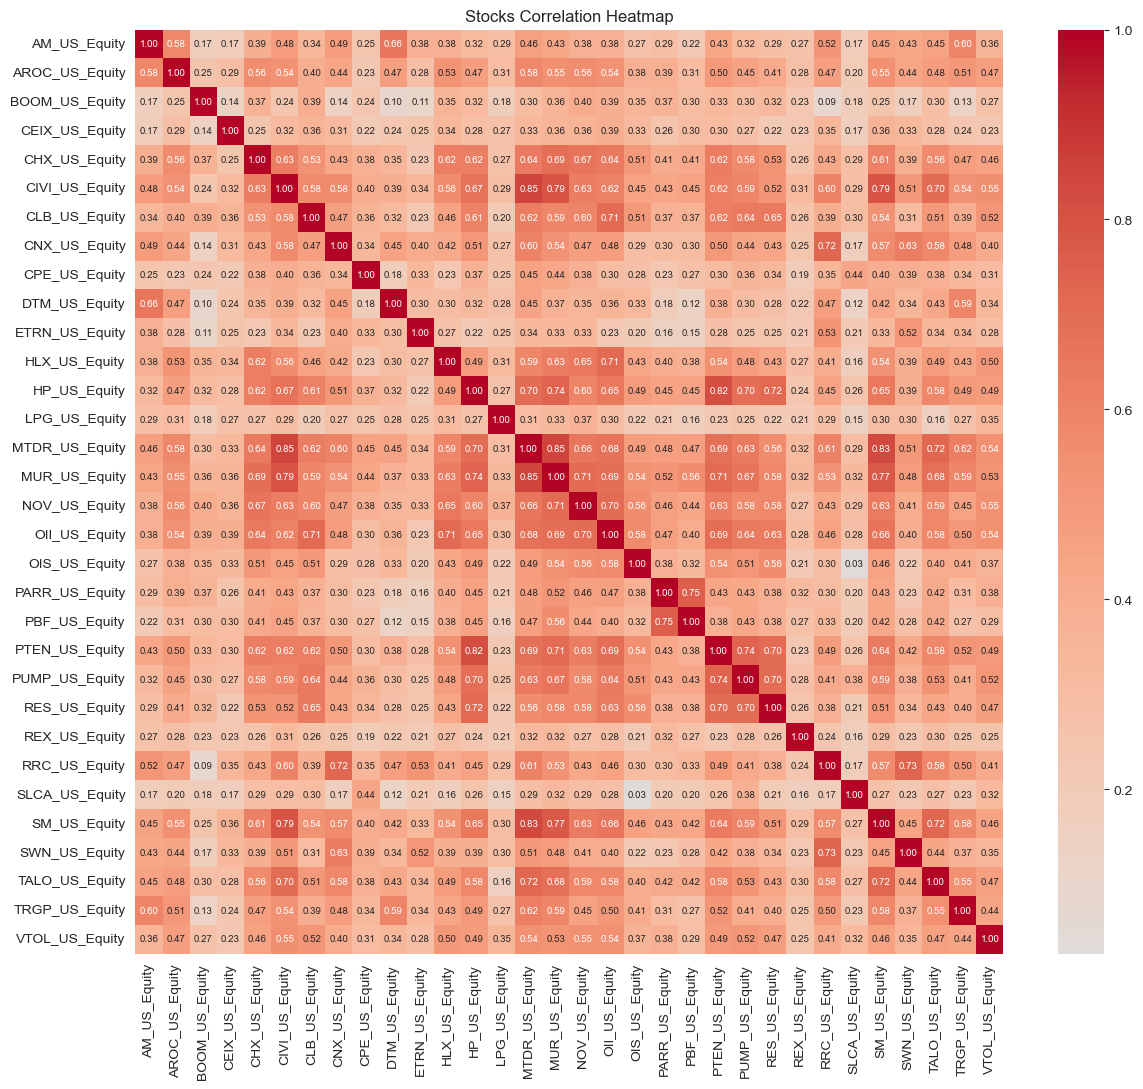

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt
# visualize using heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    cmap='coolwarm',        
    center=0,             
    fmt=".2f",            
    annot_kws={"size": 7} 
)

plt.title("Stocks Correlation Heatmap")
plt.show()

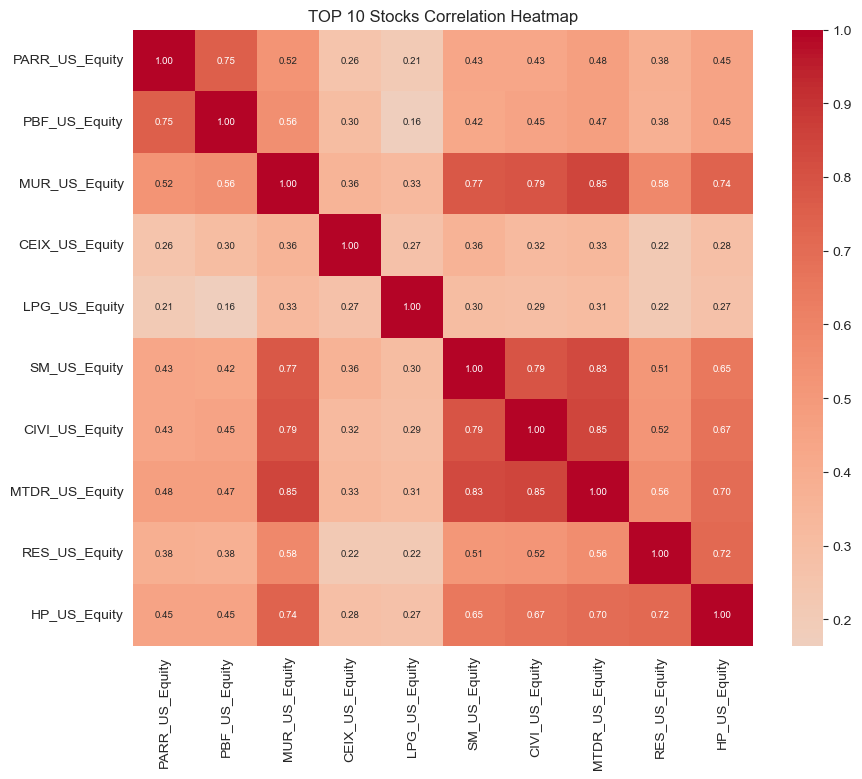

In [100]:
# Calculate top 10 stocks correlation
top_10_stocks = rank_df['Stock'][0:10]
top_10_corr = corr_matrix.loc[top_10_stocks, top_10_stocks]
# Display top 10 stocks correlation with one hot encoding
plt.figure(figsize=(10, 8))
sns.heatmap(
    top_10_corr, 
    annot=True, 
    cmap='coolwarm',        
    center=0,             
    fmt=".2f",            
    annot_kws={"size": 7} 
)
plt.title("TOP 10 Stocks Correlation Heatmap")
plt.show()

In [101]:
top_10_stocks = rank_df['Stock'][0:10]
top_10_corr = corr_matrix.loc[top_10_stocks, top_10_stocks]

# Retrieve the returns data for these stocks from returns_df
top_10_returns = returns_df[['Dates'] + list(top_10_stocks)]
display(top_10_returns)
# Calculate the average returns and covariance matrix for the top 10 stocks
expected_returns = top_10_returns.mean()  # The expected return for each stock
cov_matrix = top_10_returns.cov()         # The covariance matrix for the top 10 stocks

,Dates,PARR_US_Equity,PBF_US_Equity,MUR_US_Equity,CEIX_US_Equity,LPG_US_Equity,SM_US_Equity,CIVI_US_Equity,MTDR_US_Equity,RES_US_Equity,HP_US_Equity
0,2023-10-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2023-11-01,0.013276,0.031915,-0.001113,-0.100617,0.052684,0.012557,0.010584,0.024581,-0.008343,0.006102
2,2023-11-02,0.005484,0.014096,-0.001337,0.049516,0.087582,-0.018601,-0.009148,-0.012644,-0.019231,-0.007329
3,2023-11-03,-0.001818,-0.015768,0.029681,0.015346,0.115617,0.039424,0.031710,0.037925,0.011029,0.046334
4,2023-11-06,-0.013661,-0.030565,-0.004768,-0.001021,-0.018561,-0.016047,-0.001945,-0.012022,-0.006061,0.006326
...,...,...,...,...,...,...,...,...,...,...,...
259,2024-10-28,0.000000,0.010361,0.011416,0.011924,0.021732,0.018029,-0.001968,-0.010878,-0.005000,0.014710
260,2024-10-29,0.016043,-0.018024,-0.028066,0.014567,-0.009024,-0.034959,-0.028594,-0.022188,-0.035176,-0.022615
261,2024-10-30,-0.076023,-0.079747,-0.019774,0.009419,-0.013008,-0.003575,-0.013601,-0.003749,0.005208,-0.011866
262,2024-10-31,-0.007595,-0.008597,0.007045,-0.006523,-0.025371,0.016503,0.009261,0.024361,-0.008636,0.018313


## Visualize functions

In [102]:
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
# Visualize the portfolio's return within 1 year.
def plot_returns_over_time(best_combination, top_returns_df):
    #pick the best combination return data.
    best_combination_returns = top_returns_df[['Dates'] + list(best_combination)].set_index('Dates')

    plt.figure(figsize=(15, 6))

    for stock in best_combination_returns.columns:
        plt.plot(best_combination_returns.index, best_combination_returns[stock], label=stock)

    plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # scale monthly

    plt.title("Returns Over Time for Selected Stocks in Best Combination")
    plt.xlabel("Time")
    plt.ylabel("Returns")
    plt.legend()
    plt.grid(True)

    plt.show()

In [103]:
def plot_portfolio_returns_and_volatility(best_combination, top_returns_df, best_weights, window=20):

    # Plot the daily return and volatility.
    best_combination_returns = top_returns_df[['Dates'] + list(best_combination)].set_index('Dates')
    # Calculate the daily returns
    portfolio_daily_returns = best_combination_returns.dot(best_weights)
    # Calculate the rolling volatility
    rolling_volatility = portfolio_daily_returns.rolling(window=window).std()

    plt.figure(figsize=(15, 8))

    plt.subplot(2, 1, 1)
    plt.plot(portfolio_daily_returns.index, portfolio_daily_returns, label='Portfolio Daily Returns', color='blue')
    plt.title("Portfolio Daily Returns")
    plt.xlabel("Date")
    plt.ylabel("Returns")
    plt.legend()
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())


    plt.subplot(2, 1, 2)
    plt.plot(rolling_volatility.index, rolling_volatility, label=f'{window}-Day Rolling Volatility', color='red')
    plt.title(f"Portfolio {window}-Day Rolling Volatility")
    plt.xlabel("Date")
    plt.ylabel("Volatility")
    plt.legend()
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

    plt.tight_layout()
    plt.show()

## Based on volatility, we calculate the optimal weights for the selected stock

In [104]:
# Init
min_volatility = np.inf
best_combination = None
best_weights = None
best_corr_matrix = None

# Define the function of volatility.
def portfolio_volatility(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# The constraint is the weight should sum as 1 and Ensures return > 0.001
constraints = [
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Sum of weights = 1
    {'type': 'ineq', 'fun': lambda x: np.dot(x, expected_returns[list(combination)]) - 0.00}  # Ensures return >=0
]

# The bound should be 0 to 1 for the weight.
bounds = tuple((0, 1) for _ in range(len(top_10_stocks)))


# Since we pick the top 10 stocks, we want to know if any combination is the best, we set up a loop to go through all the possible combination.
for r in range(5, 11):
    for combination in itertools.combinations(top_10_stocks, r):
       
        comb_returns = expected_returns[list(combination)]
        comb_cov_matrix = cov_matrix.loc[list(combination), list(combination)]
        comb_corr_matrix = comb_cov_matrix.corr()  
        
        initial_weights = np.array([1 / r] * r)
        
        result = minimize(portfolio_volatility, initial_weights, args=(comb_cov_matrix,), 
                          method='SLSQP', bounds=tuple((0.1, 0.5) for _ in range(r)), constraints=constraints)
        
        # Check if the result is the best result.
        if result.success:
            comb_volatility = portfolio_volatility(result.x, comb_cov_matrix)
            
            if comb_volatility < min_volatility:
                min_volatility = comb_volatility
                best_combination = combination
                best_weights = result.x
                best_corr_matrix = comb_corr_matrix 


print("Optimal Portfolio Allocation:")
for stock, weight in zip(best_combination, best_weights):
    print(f"{stock}: {weight:.2f}")
print("Minimum portfolio volatility:", min_volatility)

optimal_portfolio_return = np.dot(best_weights, expected_returns[list(best_combination)])
print("Optimal Portfolio Expected Return:", optimal_portfolio_return)

# print("\nCorrelation matrix for the best combination:")
# print(best_corr_matrix)

Optimal Portfolio Allocation:
MUR_US_Equity: 0.14
CEIX_US_Equity: 0.26
LPG_US_Equity: 0.22
SM_US_Equity: 0.12
MTDR_US_Equity: 0.13
HP_US_Equity: 0.12
Minimum portfolio volatility: 0.016643251902217274
Optimal Portfolio Expected Return: -2.0824989410868355e-14


## Visualize the results for volatility optimization

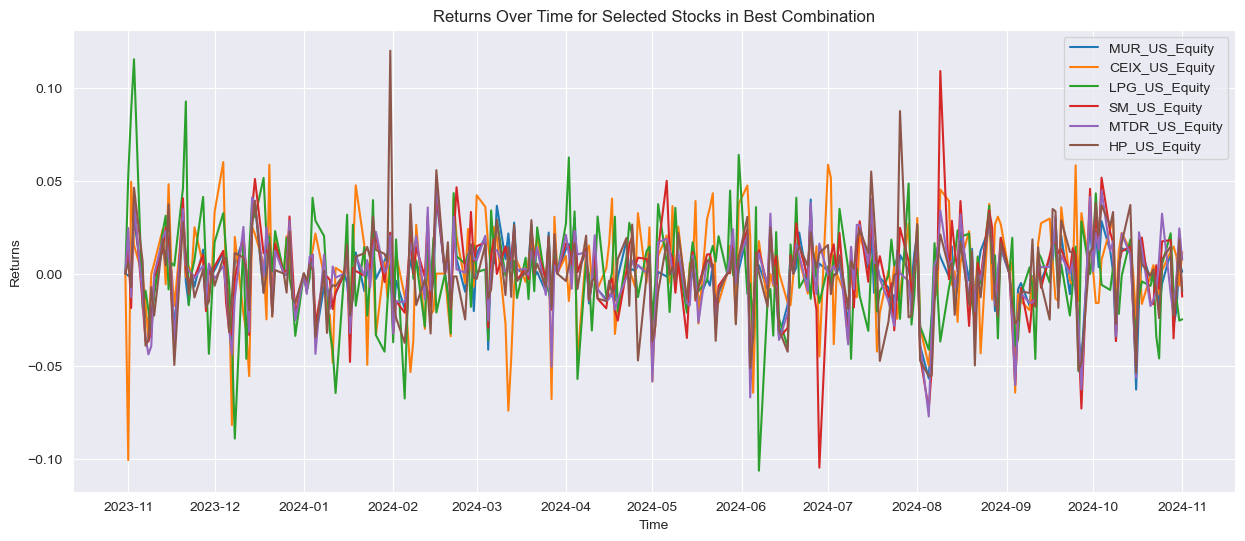

In [105]:
plot_returns_over_time(best_combination, top_10_returns)

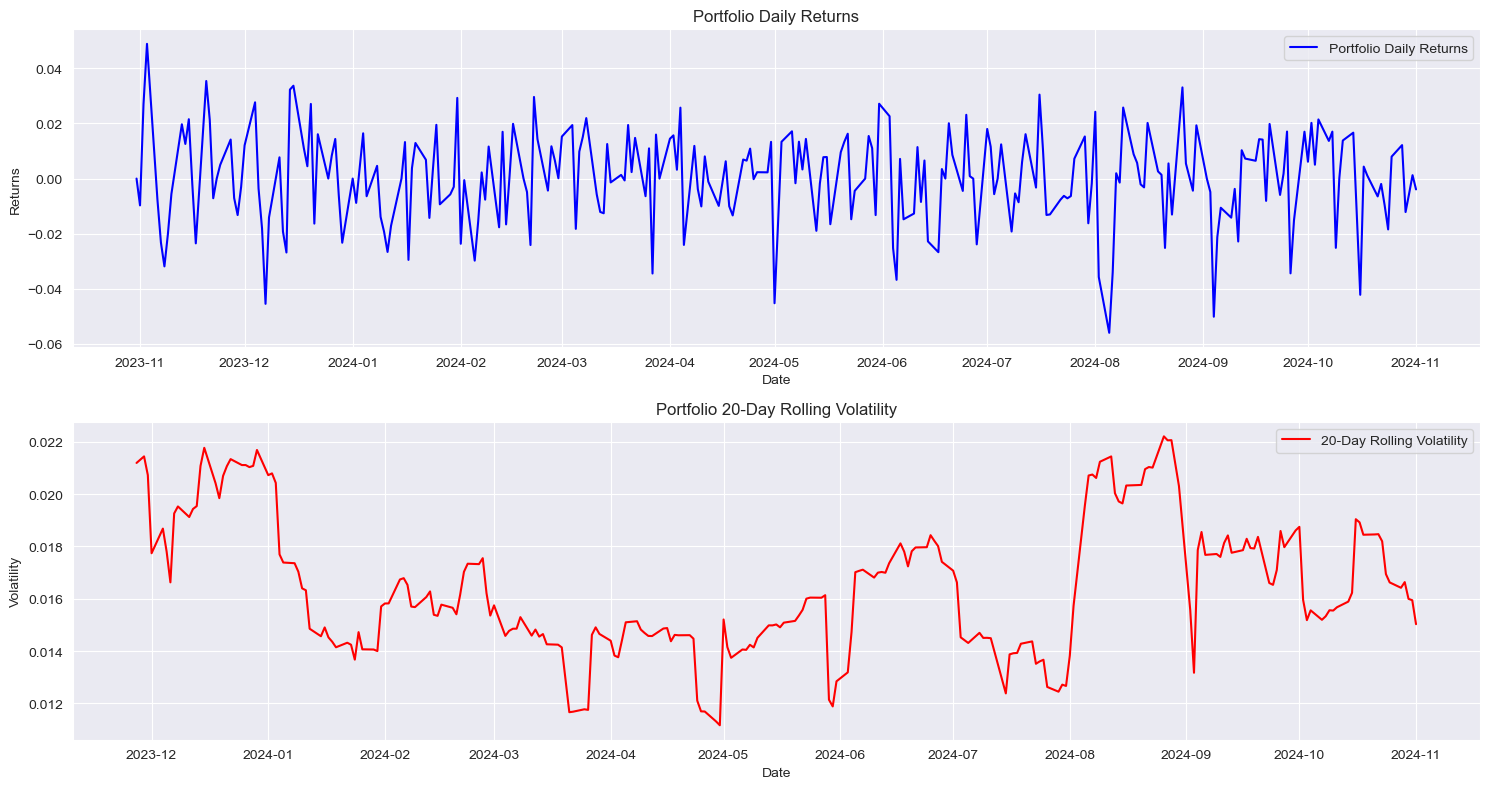

In [106]:
plot_portfolio_returns_and_volatility(best_combination, top_10_returns, best_weights)

## Based on Shape Ratio, we calculate the optimal weights for the selected stocks.

In [107]:
# We only need the data not the date column.
numeric_columns = top_10_returns.columns.difference(['Dates'])

# Calculate the top 10 expect return based on mean and cov matrix.
expected_returns = top_10_returns[numeric_columns].mean()  
cov_matrix = top_10_returns[numeric_columns].cov()         
# define the risk_free_rate here
risk_free_rate = 0.02

# define the negative sharpe_ratio, lower the better.
def neg_sharpe_ratio(weights, expected_returns, cov_matrix, risk_free_rate):
    portfolio_return = np.dot(weights, expected_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return -sharpe_ratio  

# Constrain the sum should be 1.
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Init data.
max_sharpe_ratio = -np.inf
best_combination = None
best_weights = None

# Go through all the combination and save the best result.
for r in range(5, 11):
    for combination in itertools.combinations(top_10_stocks, r):
        comb_returns = expected_returns[list(combination)]
        comb_cov_matrix = cov_matrix.loc[list(combination), list(combination)]
        
        initial_weights = np.array([1 / r] * r)
        
        # hyperparameter here, can adjust to truning the result.
        bounds = tuple((0.1, 0.5) for _ in range(r))
        
        # Optimize the weight based sharpe_ratio (since it's negative, we need find the minimum)
        result = minimize(
            neg_sharpe_ratio,
            initial_weights,
            args=(comb_returns, comb_cov_matrix, risk_free_rate),
            method='SLSQP',
            bounds=bounds,
            constraints=constraints
        )
        
        
        if result.success:
            sharpe_ratio = -result.fun
           #save the best result.
            if sharpe_ratio > max_sharpe_ratio:
                max_sharpe_ratio = sharpe_ratio
                best_combination = combination
                best_weights = np.round(result.x, 2)


optimal_portfolio_return = np.dot(best_weights, expected_returns[list(best_combination)])
optimal_portfolio_volatility = np.sqrt(np.dot(best_weights.T, np.dot(cov_matrix.loc[list(best_combination), list(best_combination)], best_weights)))


print("Optimal Portfolio Allocation:")
for stock, weight in zip(best_combination, best_weights):
    print(f"{stock}: {weight:.2f}")

print("Maximum Sharpe Ratio:", max_sharpe_ratio)
print("Optimal Portfolio Expected Return:", optimal_portfolio_return)
print("Optimal Portfolio Volatility:", optimal_portfolio_volatility)

Optimal Portfolio Allocation:
SM_US_Equity: 0.50
CIVI_US_Equity: 0.10
MTDR_US_Equity: 0.10
RES_US_Equity: 0.10
HP_US_Equity: 0.20
Maximum Sharpe Ratio: -1.0129413387251405
Optimal Portfolio Expected Return: -0.0001309130329375487
Optimal Portfolio Volatility: 0.0198737204844199


## Visualize the results for Sharpe Ratio optimization

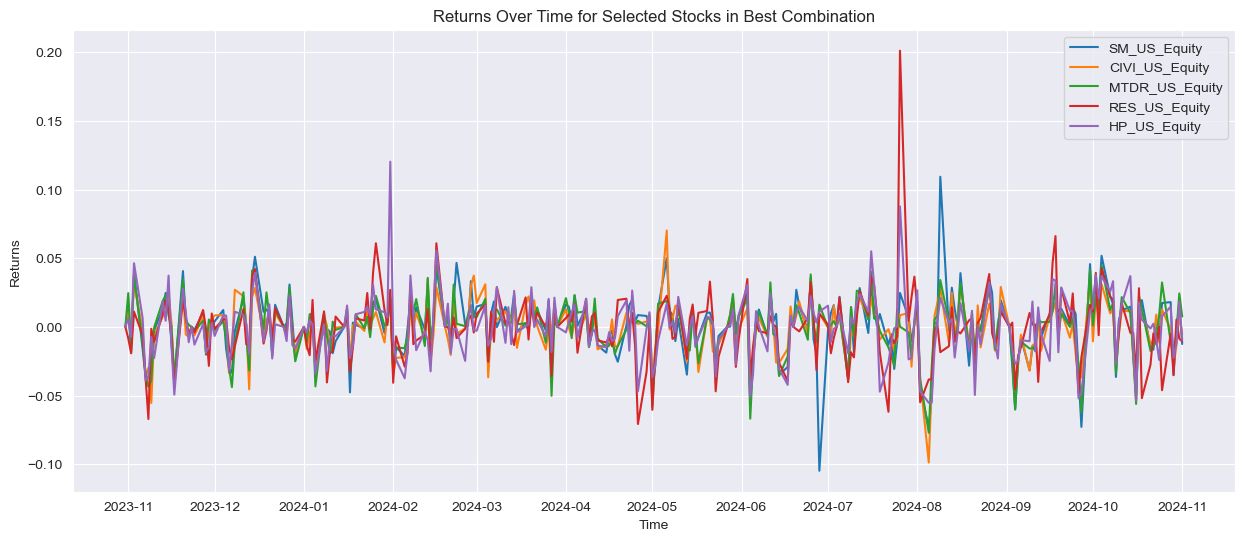

In [108]:
plot_returns_over_time(best_combination, top_10_returns)

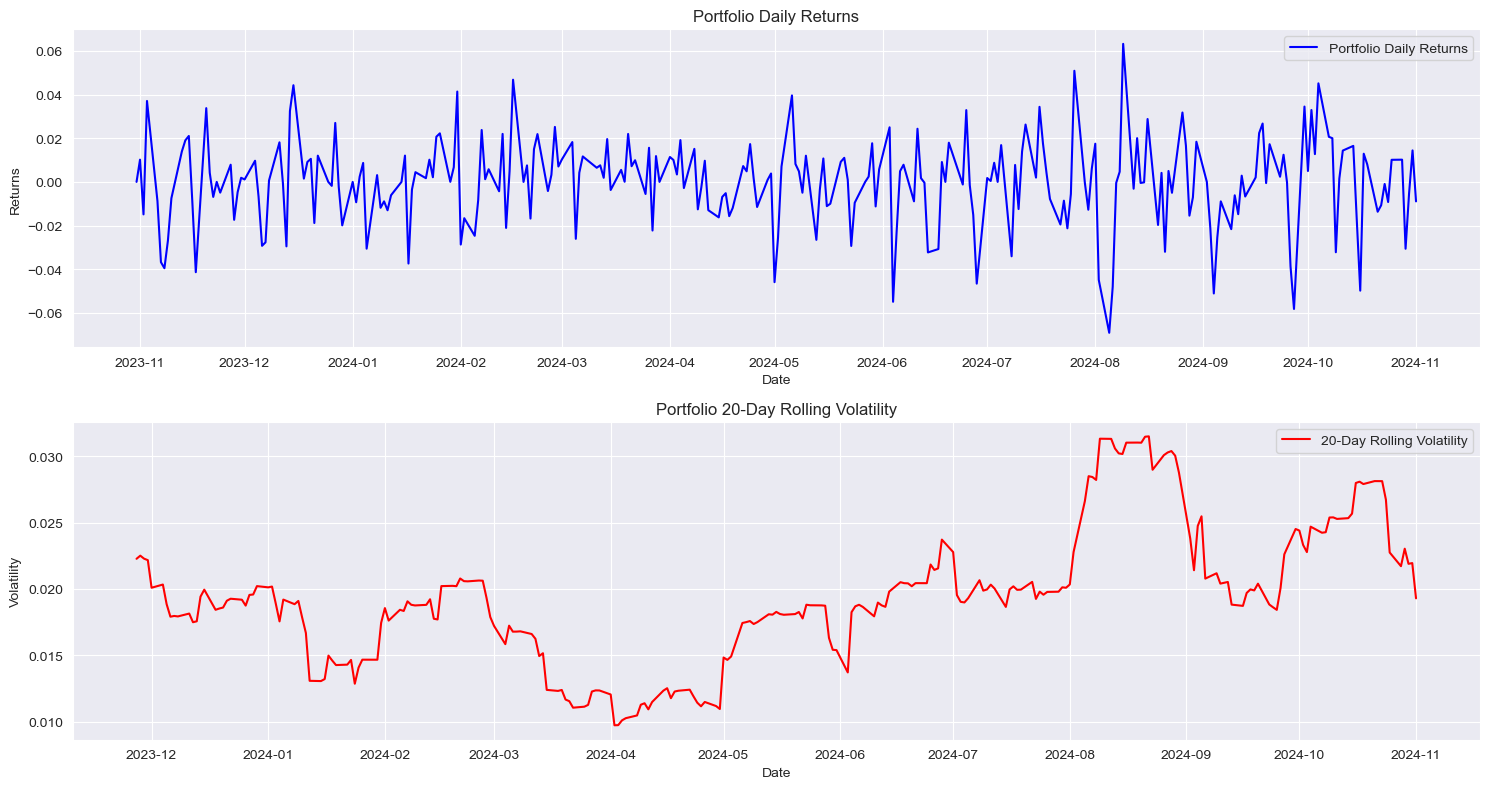

In [109]:
plot_portfolio_returns_and_volatility(best_combination, top_10_returns, best_weights)